# Progressive Growing GAN - Flickr-FacesHQ

## Brief

This Notebook does an Exploratory Data Analysis for the Dataset.

## Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## Data

### Load - Locally

In [3]:
def load_data(data_folder = "thumbnails128x128", image_height = 128, batch_size = 1000):

    # Variables
    data_folder = data_folder
    image_height = image_height
    image_width = image_height
    batch_size = batch_size

    # All 70k images used for training.
    train_data = tf.keras.preprocessing.image_dataset_from_directory(
      data_folder,
      seed=123,
      image_size=(image_height, image_width),
      batch_size=batch_size,
      validation_split = None,
      shuffle = True)
    return train_data

train_data = load_data()

Found 70000 files belonging to 1 classes.


## Exploratory Data Analysis

### Visualize - Montage

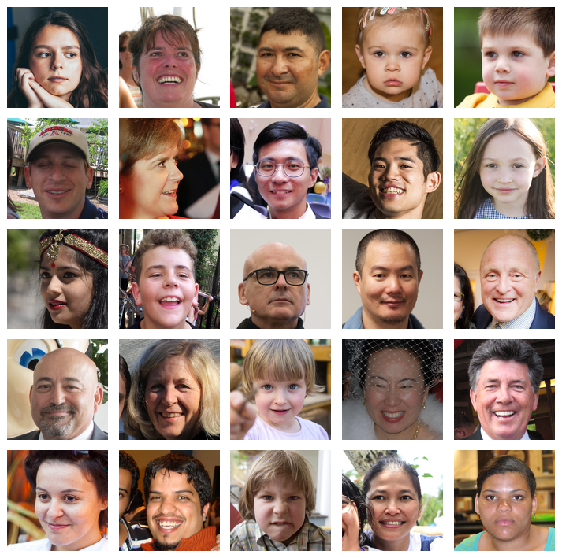

In [4]:
plt.figure(figsize=(10, 10))

for images,labels  in train_data.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        
plt.subplots_adjust(wspace=0, hspace=0.1)

### Visualize - Color Intensity

(128, 128, 3)

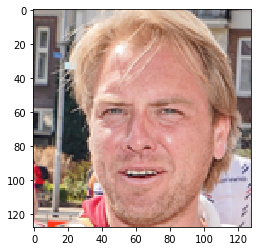

In [75]:
#show image we are looking at
plt.imshow(images[0].numpy().astype("uint8"))

#Create array version of the image, to allow for computation of the color values
array = tf.keras.preprocessing.image.img_to_array(images[0])
np.shape(array)

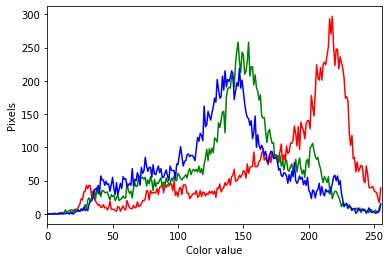

In [83]:
# Visualize the distribution of color values

# tuple to select colors of each channel line
colors = ("red", "green", "blue")
channel_ids = (0, 1, 2)

# Histogram of Color Intensity
plt.xlim([0, 256])
for channel_id, c in zip(channel_ids, colors):
    histogram, bin_edges = np.histogram(
        array[:, :, channel_id], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=c)

plt.xlabel("Color value")
plt.ylabel("Pixels")

plt.show()

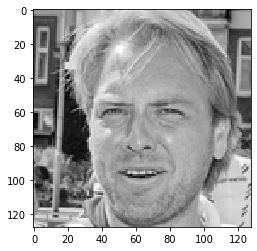

In [84]:
# Calculate Grayscale image value, by taking the dot product of the RGB values with a weighting matrix
rgb_weights = [1/3, 1/3, 1/3]
grayscale_image = np.dot(array, rgb_weights)
plt.imshow(grayscale_image, cmap=plt.get_cmap("gray"))

Text(0, 0.5, 'Pixels')

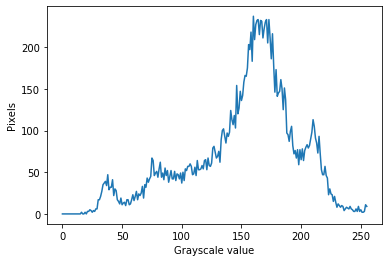

In [85]:
# Visualize Grayscale values
histogram, bin_edges = np.histogram(grayscale_image[:, :], bins=256, range=(0, 256))
plt.plot(bin_edges[0:-1], histogram)
plt.xlabel("Grayscale value")
plt.ylabel("Pixels")

Text(0, 0.5, 'Pixels')

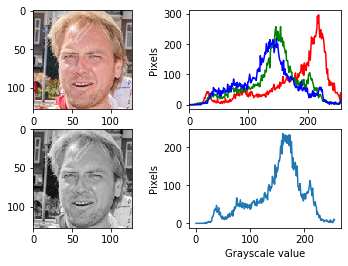

In [86]:
# All 4 Graphs side by side

f1 = plt.subplot(2, 2, 1)
plt.imshow(images[0].numpy().astype("uint8"))

f2 = plt.subplot(2, 2, 2)
plt.xlim([0, 256])
for channel_id, c in zip(channel_ids, colors):
    histogram, bin_edges = np.histogram(
        array[:, :, channel_id], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=c)
plt.xlabel("Color value")
plt.ylabel("Pixels")

f3 = plt.subplot(2, 2, 3)
plt.imshow(grayscale_image, cmap=plt.get_cmap("gray"))

f4 = plt.subplot(2, 2, 4)
histogram, bin_edges = np.histogram(grayscale_image[:, :], bins=256, range=(0, 256))
plt.plot(bin_edges[0:-1], histogram)
plt.xlabel("Grayscale value")
plt.ylabel("Pixels")


## Network Implementation

### Generator

In [4]:
def Generator():
    generator = tf.keras.Sequential()
    
    generator.add(layers.Dense(512))
    # Batch Normalization?
    
    generator.add(layers.Reshape((1, 1, 512)))
    
    # 512 x 4 x 4
    generator.add(layers.Conv2DTranspose(512, (4, 4), use_bias=False))
    generator.add(layers.LeakyReLU())
    
    generator.add(layers.Conv2DTranspose(512, (3, 3), use_bias=False))
    generator.add(layers.LeakyReLU())
    

    # 512 x 8 x 8
    generator.add(layers.UpSampling2D(interpolation="bilinear"))
    generator.add(layers.Conv2DTranspose(512, (3, 3), use_bias=False))
    generator.add(layers.LeakyReLU())
    
    generator.add(layers.Conv2DTranspose(512, (3, 3), use_bias=False))
    generator.add(layers.LeakyReLU())
    
    
    # 512 x 16 x 16
    generator.add(layers.UpSampling2D(interpolation="bilinear"))
    generator.add(layers.Conv2DTranspose(512, (3, 3), use_bias=False))
    generator.add(layers.LeakyReLU())
    
    generator.add(layers.Conv2DTranspose(512, (3, 3), use_bias=False))
    generator.add(layers.LeakyReLU())
   
    
    # 512 x 32 x 32
    generator.add(layers.UpSampling2D(interpolation="bilinear"))
    generator.add(layers.Conv2DTranspose(512, (3, 3), use_bias=False))
    generator.add(layers.LeakyReLU())
    
    generator.add(layers.Conv2DTranspose(512, (3, 3), use_bias=False))
    generator.add(layers.LeakyReLU())

    
    # 512 x 64 x 64   |   256 x 64 x 64
    generator.add(layers.UpSampling2D(interpolation="bilinear")) # 512
    generator.add(layers.Conv2DTranspose(256, (3, 3), use_bias=False))
    generator.add(layers.LeakyReLU())
    
    generator.add(layers.Conv2DTranspose(256, (3, 3), use_bias=False))
    generator.add(layers.LeakyReLU())
    
    
    # 256 x 128 x 128
    generator.add(layers.UpSampling2D(interpolation="bilinear"))
    generator.add(layers.Conv2DTranspose(128, (3, 3), use_bias=False))
    generator.add(layers.LeakyReLU())
    
    generator.add(layers.Conv2DTranspose(128, (3, 3), use_bias=False))
    generator.add(layers.LeakyReLU())
    

    # 3 x 128 x 128
    generator.add(layers.Conv2DTranspose(3, (1,1), use_bias = False))
    
    return generator


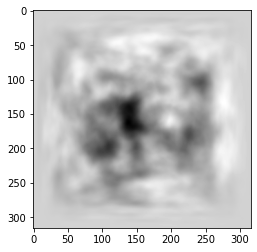

In [5]:
# Generator Check
generator = Generator()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Discriminator

In [9]:
def Discriminator():  # We could add Dropout. Not used in the paper.
    discriminator = tf.keras.Sequential()
    
    discriminator.add(layers.Conv2D(1024, (1, 1), input_shape=[128, 128, 3]))
    discriminator.add(layers.LeakyReLU())
    
    # 128 x 128 x 128
    discriminator.add(layers.Conv2DTranspose(128, (3, 3), use_bias=False))
    discriminator.add(layers.LeakyReLU())
    discriminator.add(layers.Conv2DTranspose(256, (3, 3), use_bias=False))
    discriminator.add(layers.LeakyReLU())
    discriminator.add(layers.MaxPooling2D(pool_size = (2,2)))

    # 256 x 64 x 64
    discriminator.add(layers.Conv2DTranspose(256, (3, 3), use_bias=False))
    discriminator.add(layers.LeakyReLU())
    discriminator.add(layers.Conv2DTranspose(512, (3, 3), use_bias=False)) # 512 x 64 x 64
    discriminator.add(layers.LeakyReLU())
    discriminator.add(layers.MaxPooling2D(pool_size = (2,2)))   
    
    # 512 x 32 x 32
    discriminator.add(layers.Conv2DTranspose(512, (3, 3), use_bias=False))
    discriminator.add(layers.LeakyReLU())
    discriminator.add(layers.Conv2DTranspose(512, (3, 3), use_bias=False)) # 512 x 32 x 32
    discriminator.add(layers.LeakyReLU())
    discriminator.add(layers.MaxPooling2D(pool_size = (2,2)))   
    
    # 512 x 16 x 16
    discriminator.add(layers.Conv2DTranspose(512, (3, 3), use_bias=False))
    discriminator.add(layers.LeakyReLU())
    discriminator.add(layers.Conv2DTranspose(512, (3, 3), use_bias=False)) # 512 x 16 x 16
    discriminator.add(layers.LeakyReLU())
    discriminator.add(layers.MaxPooling2D(pool_size = (2,2)))   
    
    # 512 x 8 x 8
    discriminator.add(layers.Conv2DTranspose(512, (3, 3), use_bias=False))
    discriminator.add(layers.LeakyReLU())
    discriminator.add(layers.Conv2DTranspose(512, (3, 3), use_bias=False)) # 512 x 8 x 8
    discriminator.add(layers.LeakyReLU())
    discriminator.add(layers.MaxPooling2D(pool_size = (2,2))) # 512 x 4 x 4


    # 512 x 8 x 8
    # MINIBATCH STDDEV -> 513 x 4 x 4 ??
    discriminator.add(layers.Conv2DTranspose(512, (3, 3), use_bias=False))
    discriminator.add(layers.LeakyReLU())
    discriminator.add(layers.Conv2DTranspose(512, (4, 4), use_bias=False)) # 512 x 8 x 8
    discriminator.add(layers.LeakyReLU())
    
    generator.add(layers.Dense(1))    
        
    return discriminator


In [10]:
# Discriminator Check
discriminator = Discriminator()
decision = discriminator(generated_image)
print (decision)

tf.Tensor(
[[[[-4.87998253e-11  7.33268515e-11 -2.88596317e-11 ... -7.63741327e-12
    -5.12799768e-11  1.46908874e-10]
   [-2.60155314e-10  3.53089308e-10 -2.06599279e-10 ... -5.61898306e-11
    -1.79023824e-10  9.02844022e-10]
   [-3.68223729e-10  1.16946419e-09 -3.42059353e-10 ... -4.00685291e-10
    -4.53286353e-10  2.23962404e-09]
   ...
   [ 1.14794607e-09 -7.88271670e-10 -4.07788608e-10 ...  1.55784219e-09
     2.96115410e-10  1.12172516e-09]
   [ 1.40650669e-09 -7.56510743e-10 -1.61538893e-10 ...  8.05234157e-10
     6.33044006e-10  1.18270505e-09]
   [ 1.40017276e-10 -1.98468686e-10  1.24838584e-10 ...  1.51549120e-10
     1.37532777e-10  7.07138514e-11]]

  [[-3.56718932e-10  1.82647009e-10 -1.04232345e-10 ... -1.30036815e-10
    -3.03473552e-10  7.52872209e-10]
   [-1.67014458e-09  6.60789423e-10  2.53023158e-10 ... -1.72554249e-10
    -1.03973452e-09  5.02199526e-09]
   [-5.26583399e-09  4.00979960e-09  3.19602123e-10 ...  3.16264304e-09
    -2.50360044e-09  1.42270231e-08]

## Training and Testing